<a href="https://colab.research.google.com/github/ykato27/Time-Series-Deep-Learning/blob/main/12_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 回帰結合型のニューラルネットワーク（RNN）による電力予測
---

## 目的
Reccurent Neural Network (RNN) を用いて，電力予測の実験を行なう．


## 対応するチャプター
* 10.2: 回帰結合型ネットワークにおける勾配計算（BPTT）
* 10.11: 勾配のクリッピング


## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## データのダウンロード
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍します．

In [2]:
!wget -q http://www.mprg.cs.chubu.ac.jp/tutorial/ML_Lecture/SOLAR/data.zip -O data.zip
!unzip -q -o data.zip
!ls -R ./data

./data:
test  train

./data/test:
BEMS_RNN_test_data.npy	BEMS_RNN_test_labels.npy

./data/train:
BEMS_RNN_train_data.npy  BEMS_RNN_train_labels.npy


## データの読み込み
読み込んだデータを変換します．
ここで，delayは何時刻先の電力値を教師信号にするかを決定するためのパラメータです．
delay=1と設定した場合，ネットワークへ入力したデータの1時刻先の電力が正解ラベルとなります．

データのサイズを確認します．
ネットワークへの入力データサイズは34となっており，時刻や曜日などの情報を表現したデータとなっています，出力の値は対応する電力値の1つとなっています．

In [3]:
# データの読み込み
train_x = np.load('./data/train/BEMS_RNN_train_data.npy')
train_y = np.load('./data/train/BEMS_RNN_train_labels.npy')
test_x  = np.load('./data/test/BEMS_RNN_test_data.npy')
test_y = np.load('./data/test/BEMS_RNN_test_labels.npy')

# 0~1に収まるように正規化
train_x = (train_x - (-0.04)) / (1.3 - (-0.04))
train_y = (train_y - (-0.04)) / (1.3 - (-0.04))
test_x = (test_x - (-0.04)) / (1.3 - (-0.04))
test_y = (test_y - (-0.04)) / (1.3 - (-0.04))

# 数時刻先の電力が正解データになるように変換
delay = 1
train_x = np.asarray(train_x[ : -delay])
train_y = np.asarray(train_y[delay : ])
test_x = np.asarray(test_x[ : -delay])
test_y = np.asarray(test_y[delay : ])

# データのサイズ確認
train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(test_y), 1)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(49999, 34) (49999, 1)
(9999, 34) (9999, 1)


## ネットワークモデルの定義
次にネットワーク（RNN）を定義します．

まずはじめに，ネットワークの定義に必要な関数を定義します．

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
#     return (1.0 - sigmoid(x)) * sigmoid(x)
    return (1.0 - x) * x

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
#     return 1.0 - np.tanh(x) * np.tanh(x)
    return 1.0 - x**2

def fc(x, w, b):
    return np.dot(w, x) + b

def fc_grad(dout, x, w, b):
    dx = np.dot(dout, w.T)
    d_w = np.dot(x.T, dout)
    d_b = np.sum(dout, axis=0)
    return dx, d_w, d_b

def mean_squared_error(pred, true):
    return np.sum(np.power(pred - true, 2))

次に，上で定義した関数を用いてネットワークを定義します．
ここでは，RNN層，出力層から構成されるネットワークとします．

入力層と中間層，出力層のユニット数は引数として与え，それぞれ`n_input`，`n_hidden`, `n_out`とします．
そして，`__init__`関数を用いて，ネットワークのパラメータを初期化します．
下記のプログラムのうち，`w_x`, `w_h`, `w_b`はRNNが持つパラメータを表しています．
`w`と`b`はそれぞれ出力層の重みとバイアスを表しています．
重みは`randn`関数で，標準正規分布に従った乱数で生成した値を保有する配列を生成します．
バイアスは`zeros`関数を用いて，要素が全て0の配列を生成します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．

次に，`backward`関数ではパラメータの更新量を計算します．
まず，ネットワークの出力結果と教師ラベルから，誤差`dy`を算出します．
この時，教師ラベルをone-hotベクトルへ変換し，各ユニットの出力との差を取ることで，`dy`を計算しています．
その後，連鎖律に基づいて，出力層から順番に勾配を計算していきます．
このとき，パラメータの更新量を`self.grads`へ保存しておきます．
また，RNNでは時刻間で隠れ層に対する勾配を伝播する必要があるため，
`backward`の引数として，1時刻先からの勾配情報を受け取り，前の時刻へ渡す勾配情報を返すようにしています．

最後に`update_parameters`関数で，更新量をもとにパラメータの更新を行います．

また，各時刻で求めた勾配を累積する必要があるため，`clear_grads`関数で，各パラメータの勾配情報を初期化する関数を定義し，学習時に使用します．

`clip_gradients`関数は，獲得した勾配を指定した範囲に収める関数です．
LSTMでは，各時刻の勾配を累積するため，勾配量が大きくなり勾配消失や爆発が起きる可能性があります．
ここでは，指定した範囲内に勾配を調整し，パラメータを更新することで，消失や爆発を抑制します．

In [5]:
class RNN:
    
    def __init__(self, n_input, n_hidden, n_out, w_std=0.01):
        self.n_hidden = n_hidden
        
        # RNN params
        self.w_x = np.random.randn(n_input, n_hidden) * w_std
        self.w_h = np.random.randn(n_hidden, n_hidden) * w_std
        self.w_b = np.zeros(n_hidden)
        
        # output layer
        self.w = np.random.randn(n_hidden, n_out) * w_std
        self.b = np.zeros(n_out)

        self.grads = {}
        self.clear_grads()
        
    def forward(self, x, h_prev):
        
        # RNN layer
        self.h = tanh( np.dot(x, self.w_x) + np.dot(h_prev, self.w_h) + self.w_b)
        
        # output layer
        self.y = np.dot(self.h, self.w) + self.b
        
        variables = {'x': x, 'h_prev': h_prev, 'h': self.h, 'y': self.y}
        
        return variables, self.h

    
    def backward(self, in_var, t, d_h_next):
        batch_size = in_var['x'].shape[0]
        y = in_var['y']

        # output (MSE)
        dy = (t - y) / batch_size
        
        # output layer
        self.grads['w'] += np.dot(in_var['h'].T, dy)
        self.grads['b'] += np.sum(dy, axis=0)
        
        # RNN layer
        d_t = np.dot(dy, self.w.T) + d_h_next
        d_t = tanh_grad(d_t) * d_t
        d_h_prev = np.dot(d_t, self.w_h)
        
        self.grads['w_b'] += np.sum(d_t, axis=0)
        self.grads['w_h'] += np.dot(in_var['h_prev'].T, d_t)
        self.grads['w_x'] = np.dot(in_var['x'].T, d_t)

        d_x = np.dot(d_t, self.w_x.T)
        
        return d_x, d_h_prev
        
    def update_parameters(self, lr=0.01):
        self.w_x += lr * self.grads['w_x']
        self.w_h += lr * self.grads['w_h']
        self.w_b += lr * self.grads['w_b']
        self.w   += lr * self.grads['w'] 
        self.b   += lr * self.grads['b'] 

    def clear_grads(self):
        self.grads = {'w_x': np.zeros(self.w_x.shape), 'w_h': np.zeros(self.w_h.shape), 'w_b': np.zeros(self.w_b.shape),
                      'w': np.zeros(self.w.shape), 'b': np.zeros(self.b.shape)}
        
    def clip_gradients(self, clip_val=1.0):
        for k in self.grads.keys():
            self.grads[k] = np.clip(self.grads[k], -clip_val, clip_val)

## 学習データの変換

上で読み込んだ学習・テストデータは電力の推移を表した１つの時系列データとなっているため，この一つの時系列データから，短い時間間隔で区切ったデータを作成することで，学習データの作成を行います．

まず，time_windowで1サンプルの時間窓を決定します．
今回は10時刻で1サンプルと設定します．
その後，指定した時間窓でサンプルを抽出し，convert_train_x, とconvert_train_yへと保存することで，学習データを作成します．

In [6]:
time_window = 10

convert_train_x = []
convert_train_y = []
for idx_frame in range(len(train_x) - time_window):
    partial_data = train_x[idx_frame:idx_frame + time_window]
    partial_label = train_y[idx_frame:idx_frame + time_window]

    convert_train_x.append(partial_data)
    convert_train_y.append(partial_label)

convert_train_x = np.asarray(convert_train_x)
convert_train_y = np.asarray(convert_train_y)

print(convert_train_x.shape, convert_train_y.shape)

(49989, 10, 34) (49989, 10, 1)


## ネットワークの作成と学習の準備
上で定義したネットワークを作成します．

In [7]:
n_in = 34
n_hidden = 128
n_out = 1

model = RNN(n_in, n_hidden, n_out)

## 学習
学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

学習データは毎回ランダムに決定するため，numpyの`permutation`という関数を利用します．
各更新において，学習用データと教師データをそれぞれ`x_batch`と`y_batch`とします．

まず，RNNに用いる，隠れ状態`h`を初期化します．

その後，`x_batch`に含まれる各時刻の入力データを順次LSTMへと入力します．
この時，勾配計算のために，各時刻の出力を保存しておきます．

その後，`backward`関数を用いて勾配を計算します．
まず，1時刻先の勾配として`d_h_next`を初期化します．
そして，勾配を計算する前に，`clear_grads`関数を用いて，累積する勾配情報を初期化します．
その後，入力とは逆の順番にデータを取得し，backward関数を適用します．

勾配の爆発を防ぐために，`clip_gradients`を用いて，一定量に収め，`update_parameters`でパラメータを更新します．

In [8]:
train_data_num = convert_train_x.shape[0]
batch_size = 100
epoch_num = 10

iteration = 1
for epoch in range(1, epoch_num + 1):
    
    sum_accuracy = 0.0
    sum_loss = 0.0
    
    perm = np.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x_batch = convert_train_x[perm[i:i+batch_size]]
        y_batch = convert_train_y[perm[i:i+batch_size]]
        
        # forward
        h = np.zeros((x_batch.shape[0], n_hidden))

        var_list = []
        loss_tmp = 0.0
        for i in range(time_window):
            var_tmp, h = model.forward(x_batch[:, i, :], h)
            loss_tmp += mean_squared_error(sigmoid(var_tmp['y']), y_batch[:, i, :])
            var_list.append(var_tmp)

        sum_loss  += loss_tmp / time_window

        # backward
        d_h_next = np.zeros_like(h)
        
        model.clear_grads()
        for i, var_tmp in enumerate(reversed(var_list)):
            _, d_h_next = model.backward(var_tmp, y_batch[:, time_window - i - 1, :], d_h_next)
        
        model.clip_gradients(clip_val=3.0)
        model.update_parameters(lr=0.05)
    
        if iteration % 100 == 0:
            print("iteration: {}, loss: {}".format(iteration, loss_tmp / time_window / x_batch.shape[0]))
        
        iteration += 1
        
    print("epoch: {}, mean loss: {}".format(epoch, sum_loss / train_data_num))

iteration: 100, loss: 0.0914172975052929
iteration: 200, loss: 0.09542782430434055
iteration: 300, loss: 0.09942456332194473
iteration: 400, loss: 0.08304920790569226
iteration: 500, loss: 0.0876822466486467
epoch: 1, mean loss: 0.08759099115439009
iteration: 600, loss: 0.07304759598231823
iteration: 700, loss: 0.07808504290507559
iteration: 800, loss: 0.08311450798867061
iteration: 900, loss: 0.08788585585463135
iteration: 1000, loss: 0.07984294468578212
epoch: 2, mean loss: 0.08029420553061961
iteration: 1100, loss: 0.07666426527914004
iteration: 1200, loss: 0.08380555935396278
iteration: 1300, loss: 0.07068204201617673
iteration: 1400, loss: 0.0781492426210977
iteration: 1500, loss: 0.06860493676769654
epoch: 3, mean loss: 0.08007264872421632
iteration: 1600, loss: 0.08191561069033236
iteration: 1700, loss: 0.08345529787400413
iteration: 1800, loss: 0.08436400935889388
iteration: 1900, loss: 0.0753466685897941
iteration: 2000, loss: 0.08407926031016522
epoch: 4, mean loss: 0.0799736

## テスト
学習したネットワークを用いて，テストデータに対する出力結果の確認を行います．

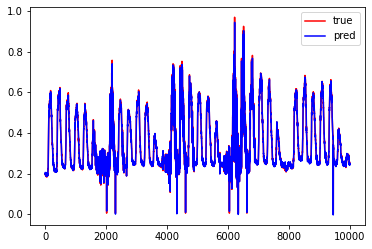

In [9]:
convert_test_x = test_x.reshape(1, 9999, 34)
convert_test_y = test_y.reshape(1, 9999, 1)

h = np.zeros((convert_test_x.shape[0], n_hidden))

result = []
for i in range(convert_test_x.shape[1]):
    var_tmp, h = model.forward(convert_test_x[:, i, :], h)
    result.append(var_tmp['y'])

prediction_result = np.array(result).flatten()

plt.figure()
plt.plot(test_y.tolist(), color='red', label='true')
plt.plot(prediction_result.tolist(), color='blue', label='pred')
plt.legend()
plt.show()